# Text Classification with TFDF and pretrained embeddings

In [199]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
import copy
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### Download and inspect dataset

In [2]:
# Turn .csv files into pandas DataFrame's
df = pd.read_csv(
    "https://raw.githubusercontent.com/IMvision12/Tweets-Classification-NLP/main/train.csv"
)
print(df.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [3]:
print(f"Training dataset shape: {df.shape}")

Training dataset shape: (7613, 5)


In [4]:
'''
랜덤하게 셔플
text 와 target 만 남기고 id, keyword, location 열은 제거함
'''

df_shuffled = df.sample(frac=1, random_state=42)
# Dropping id, keyword and location columns as these columns consists of mostly nan values
# we will be using only text and target columns
df_shuffled.drop(["id", "keyword", "location"], axis=1, inplace=True)
df_shuffled.reset_index(inplace=True, drop=True)
print(df_shuffled.head())


                                                text  target
0  So you have a new weapon that can cause un-ima...       1
1  The f$&amp;@ing things I do for #GISHWHES Just...       0
2  DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...       1
3  Aftershock back to school kick off was great. ...       0
4  in response to trauma Children of Addicts deve...       0


In [5]:
print(df_shuffled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB
None


In [6]:
print(
    "Total Number of disaster and non-disaster tweets: "
    f"{df_shuffled.target.value_counts()}"
)

Total Number of disaster and non-disaster tweets: 0    4342
1    3271
Name: target, dtype: int64


In [7]:
for index, example in df_shuffled[:5].iterrows():
    print(f"Example # {index}")
    print(f"\tTarget : {example['target']}")
    print(f"\tText : {example['text']}")

Example # 0
	Target : 1
	Text : So you have a new weapon that can cause un-imaginable destruction.
Example # 1
	Target : 0
	Text : The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@
Example # 2
	Target : 1
	Text : DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q
Example # 3
	Target : 0
	Text : Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.
Example # 4
	Target : 0
	Text : in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3


In [8]:
'''
10% 를 테스트셋으로 사용
'''
test_df = df_shuffled.sample(frac=0.1, random_state=42)
train_df = df_shuffled.drop(test_df.index)
print(f"Using {len(train_df)} samples for training and {len(test_df)} for validation")

Using 6852 samples for training and 761 for validation


In [9]:
print(train_df["target"].value_counts())

0    3929
1    2923
Name: target, dtype: int64


In [10]:
print(test_df["target"].value_counts())

0    413
1    348
Name: target, dtype: int64


### Dataset 생성

In [11]:
'''
pd.dataframe -> numpy -> Dataset
batch_size = 100
prefetch: 다음 배치 미리 대기
'''

def create_dataset(dataframe):
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].to_numpy(), dataframe["target"].to_numpy())
    )
    dataset = dataset.batch(100)  
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_ds = create_dataset(train_df)
test_ds = create_dataset(test_df)

2022-10-24 13:15:30.656600: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-24 13:15:30.656640: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: BigBoy
2022-10-24 13:15:30.656648: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: BigBoy
2022-10-24 13:15:30.656773: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.73.5
2022-10-24 13:15:30.656799: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.73.5
2022-10-24 13:15:30.656807: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.73.5
2022-10-24 13:15:30.660008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perf

## Universal Sentence Encoder

https://amitness.com/2020/06/universal-sentence-encoder/

In [12]:
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4"
)

## GBTM model with Universal Sentence Encoder as preprocessor 

In [13]:
inputs = layers.Input(shape=(), dtype=tf.string)
embeddings = sentence_encoder_layer(inputs)
preprocessor = keras.Model(inputs=inputs, outputs=embeddings)
model_1 = tfdf.keras.GradientBoostedTreesModel(preprocessing=preprocessor)

Use /tmp/tmpigxg_xsq as temporary training directory


In [14]:
print(preprocessor.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
Total params: 256,797,824
Trainable params: 0
Non-trainable params: 256,797,824
_________________________________________________________________
None


## GBTM model without preprocessor

In [15]:
model_2 = tfdf.keras.GradientBoostedTreesModel()

Use /tmp/tmprg86mkrj as temporary training directory


## Model training

In [16]:
# Compiling model_1
model_1.compile(metrics=["Accuracy", "Recall", "Precision", "AUC"])
# Here we do not specify epochs as, TF-DF trains exactly one epoch of the dataset
model_1.fit(train_ds)

# Compiling model_2
model_2.compile(metrics=["Accuracy", "Recall", "Precision", "AUC"])
# Here we do not specify epochs as, TF-DF trains exactly one epoch of the dataset
model_2.fit(train_ds)

Reading training dataset...
Training dataset read in 0:00:09.787225. Found 6852 examples.
Training model...
Model trained in 0:00:38.593063
Compiling model...


[INFO kernel.cc:1176] Loading model from path /tmp/tmpigxg_xsq/model/ with prefix 2bf67c22d6db4a56
[INFO abstract_model.cc:1248] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1022] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.116416. Found 6852 examples.
Training model...
Model trained in 0:00:00.293263
Compiling model...


[INFO kernel.cc:1176] Loading model from path /tmp/tmprg86mkrj/model/ with prefix 2ee71d45cf854220
[INFO kernel.cc:1022] Use fast generic engine


Model compiled.


In [18]:
inspector_1 = model_1.make_inspector()
log_1 = inspector_1.training_logs()
log_1

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=0.5656716227531433, loss=1.3077609539031982, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=0.6865671873092651, loss=1.2614209651947021, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=0.7417910695075989, loss=1.2177786827087402, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=0.7701492309570312, loss=1.1783922910690308, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=0.7776119112968445, loss=1.1459333896636963, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=0.7835820913314819, loss=1.1136521100997925, rmse=No

In [19]:
inspector_2 = model_2.make_inspector()
log_2 = inspector_2.training_logs()
log_2

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=0.5656716227531433, loss=1.3685380220413208, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3679413795471191, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3674567937850952, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3670554161071777, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3667176961898804, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.366430401802063, rmse=Non

## Tree model inspection

In [20]:
tree_1 = inspector_1.extract_all_trees()[0]
print(tree_1)
print()
print(tree_1.root.condition)

(model/keras_layer/StatefulPartitionedCall:0.50 >= -0.014104973524808884; miss=True, score=0.031122880056500435)
    ├─(pos)─ (model/keras_layer/StatefulPartitionedCall:0.166 >= 0.059484273195266724; miss=False, score=0.012746981345117092)
    │        ├─(pos)─ (model/keras_layer/StatefulPartitionedCall:0.463 >= -0.04945472255349159; miss=True, score=0.024406546726822853)
    │        │        ├─(pos)─ (model/keras_layer/StatefulPartitionedCall:0.188 >= -0.0009577171877026558; miss=True, score=0.01889970153570175)
    │        │        │    ...
    │        │        └─(neg)─ (model/keras_layer/StatefulPartitionedCall:0.127 >= 0.051065877079963684; miss=False, score=0.01916424371302128)
    │        │             ...
    │        └─(neg)─ (model/keras_layer/StatefulPartitionedCall:0.458 >= -0.06685502827167511; miss=True, score=0.006983840838074684)
    │                 ├─(pos)─ (model/keras_layer/StatefulPartitionedCall:0.469 >= -0.06398351490497589; miss=True, score=0.003774484153836

In [21]:
tree_2 = inspector_2.extract_all_trees()[0]
print(tree_2)
print()
print(tree_2.root.condition)

(data:0 in ['11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...', 'Madhya Pradesh Train Derailment: Village Youth Saved Many Lives', '#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade be\x89Û_']; miss=False, score=0.0009629607666283846)
    ├─(pos)─ RegressionValue(value=0.23487842082977295,sd=5.365848350575748e-05,n=18.0) (idx=3)
    └─(neg)─ (data:0 in ['<OOD>', '11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...', "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'Madhya Pradesh Train Derailment: Village Youth Saved Many Lives', '#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade b

In [22]:
print("model_1 summary: ")
print(model_1.summary())

model_1 summary: 
Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               256797824 
                                                                 
Total params: 256,797,825
Trainable params: 0
Non-trainable params: 256,797,825
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (512):
	model/keras_layer/StatefulPartitionedCall:0.0
	model/keras_layer/StatefulPartitionedCall:0.1
	model/keras_layer/StatefulPartitionedCall:0.10
	model/keras_layer/StatefulPartitionedCall:0.100
	model/keras_layer/StatefulPartitionedCall:0.101
	model/keras_layer/StatefulPartitionedCall:0.102
	model/keras_layer/StatefulPartitionedCall:0.103
	model/keras_layer/StatefulPartitionedCall:0.104
	model/keras_layer/StatefulPartitionedCall:0.105
	model

In [23]:
print("model_2 summary: ")
print(model_2.summary())

model_2 summary: 
Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (1):
	data:0

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__LABEL"  2.250000 ################
    2.  "data:0"  0.000000 

Variable Importance: NUM_AS_ROOT:
    1. "data:0" 117.000000 

Variable Importance: NUM_NODES:
    1. "data:0" 351.000000 

Variable Importance: SUM_SCORE:
    1. "data:0" 32.035971 



Loss: BINOMIAL_LOG_LIKELIHOOD
Validation loss value: 1.36429
Number of trees per iteration: 1
Node format: NOT_SET
Number of trees: 117
Total number of nodes: 819

Number of nodes by tree:
Count: 117 Average: 7 StdDev: 0
Min: 7 Max: 7 Ignored: 0
-------------------------------

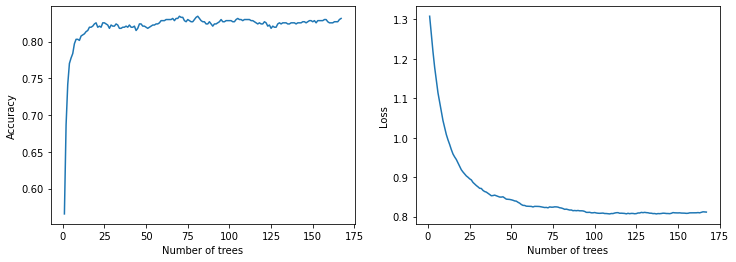

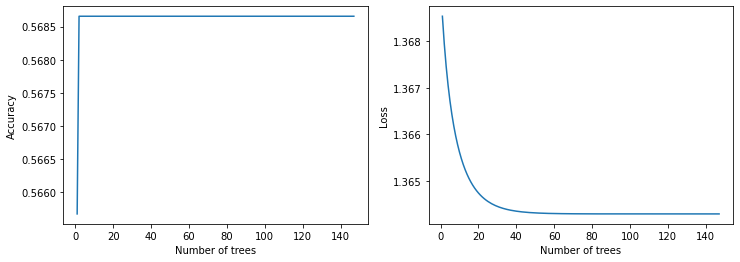

In [24]:
def plot_curve(logs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")

    plt.show()


plot_curve(log_1)
plot_curve(log_2)

## Evaluation

In [25]:
results = model_1.evaluate(test_ds, return_dict=True, verbose=0)
print("**  model_1 Evaluation: \n")
for name, value in results.items():
    print(f"{name}: {value:.4f}")

print('\n\n')
    
results = model_2.evaluate(test_ds, return_dict=True, verbose=0)
print("** model_2 Evaluation: \n")
for name, value in results.items():
    print(f"{name}: {value:.4f}")

**  model_1 Evaluation: 

loss: 0.0000
Accuracy: 0.8160
recall: 0.7241
precision: 0.8514
auc: 0.8700



** model_2 Evaluation: 

loss: 0.0000
Accuracy: 0.5440
recall: 0.0029
precision: 1.0000
auc: 0.5026


In [26]:
test_df.reset_index(inplace=True, drop=True)
for index, row in test_df.iterrows():
    text = tf.expand_dims(row["text"], axis=0)
    preds = model_1.predict_step(text)
    preds = tf.squeeze(tf.round(preds))
    print(f"Index: {index} Text: {row['text']}")
    print(f"Prediction: {int(preds)}")
    print(f"Ground Truth : {row['target']}")
    if index == 10:
        break

Index: 0 Text: DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5
Prediction: 0
Ground Truth : 0
Index: 1 Text: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday
Prediction: 1
Ground Truth : 0
Index: 2 Text: Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj
Prediction: 1
Ground Truth : 1
Index: 3 Text: @camilacabello97 Internally and externally screaming
Prediction: 0
Ground Truth : 1
Index: 4 Text: Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov
Prediction: 1
Ground Truth : 1
Index: 5 Text: Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8
Prediction: 1
Ground Truth : 1
Index: 6 Text: How the West was burned: Thousa

## Comparision with neural-net classifier 

In [217]:
sencoder = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4"
)

inputs = layers.Input(shape=(), dtype=tf.string)
embeddings = sencoder(inputs)
hidden = layers.Dense(units=512, activation='relu')(embeddings)
hidden = layers.Dropout(rate=0.5)(hidden)
hidden = layers.Dense(units=32)(hidden)
nn_outputs = layers.Dense(units=1)(hidden)
nn_model = keras.Model(inputs=inputs, outputs=nn_outputs)

In [218]:
nn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                 loss=keras.losses.BinaryCrossentropy(),
                 metrics=["Accuracy", "Recall", "Precision", "AUC"])

In [219]:
nn_model.fit(train_ds, epochs=30, batch_size=128)

Epoch 1/30
69/69 [==============================] - 3s 11ms/step - loss: 0.9665 - Accuracy: 0.5944 - recall: 0.0602 - precision: 0.8462 - auc: 0.6287
Epoch 2/30
69/69 [==============================] - 1s 11ms/step - loss: 0.5778 - Accuracy: 0.7176 - recall: 0.4489 - precision: 0.8020 - auc: 0.7830
Epoch 3/30
69/69 [==============================] - 1s 12ms/step - loss: 0.5256 - Accuracy: 0.7744 - recall: 0.6681 - precision: 0.7722 - auc: 0.8334
Epoch 4/30
69/69 [==============================] - 1s 15ms/step - loss: 0.4928 - Accuracy: 0.7874 - recall: 0.7188 - precision: 0.7679 - auc: 0.8521
Epoch 5/30
69/69 [==============================] - 1s 13ms/step - loss: 0.4978 - Accuracy: 0.7951 - recall: 0.7362 - precision: 0.7727 - auc: 0.8607
Epoch 6/30
69/69 [==============================] - 1s 12ms/step - loss: 0.4770 - Accuracy: 0.7979 - recall: 0.7349 - precision: 0.7788 - auc: 0.8677
Epoch 7/30
69/69 [==============================] - 1s 12ms/step - loss: 0.4757 - Accuracy: 0.8059 -

In [220]:
evaluation = nn_model.evaluate(test_ds, return_dict=True, verbose=0)
for k, v in evaluation.items():
    print(k, v)

loss 0.5000346302986145
Accuracy 0.8134034276008606
recall 0.727011501789093
precision 0.8433333039283752
auc 0.8689919710159302


In [107]:
results = model_1.evaluate(test_ds, return_dict=True, verbose=0)
print("**  model_1 Evaluation: \n")
for name, value in results.items():
    print(f"{name}: {value:.4f}")

**  model_1 Evaluation: 

loss: 0.0000
Accuracy: 0.8160
recall: 0.7241
precision: 0.8514
auc: 0.8700
